<h2><center><font color='Green'> CVEN 5370: GIS Applications for Civil Engineering </center></h2>

<h3><font color='teal'><center> Final Exam / Project
<h3><font color='teal'><center> Watershed Delineation (Lumberton, TX)

<h3><font color='teal'><center> MD RASHEDUL ISLAM

<h4> Workflow

The computation entails the following steps.
<ol>
<li> Extract the city of interest polygon vector file. Create a crude outline for download purposes </li>
<li> Download the DEM files. You may have to merge multiple DEMs (USGS Earth Explorer) </li>
<li> Use the DEMs from step 2 and vector file from step 1 to find the lowest elevation within the city limits. </li>
<li> Use a larger DEM to delineate a watershed (this is because the watershed boundary can be outside the city limits). Plot the DEMs to find the upstream areas near the city to guide the size of the DEM </li>
<li> Delineate the watersheds using the Pysheds package (the illustration there is self-explanatory) </li>
<li> Polygonize and find the area of the corresponding watershed. </li>
</ol>

<h4> Codes

<h4> Load Libraries

In [ ]:
#!pip install rasterio
#!pip install matplotlib
#!pip install pysheds
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
import matplotlib.pyplot as plt
import os
import geopandas as gpd
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt

<h4> Set Working Directory

In [16]:
#set working directory
os.chdir("G:\\GIS\\Final Project\\Final_Project_Watershed")
os.getcwd()

'G:\\GIS\\Final Project\\Final_Project_Watershed'

In [10]:
#List of .BIL files to read
bil_files = ["n30_w095_3arc_v2.bil"]

#Open each file and add to a list of datasets
datasets = [rasterio.open(file) for file in bil_files]

#MArge the datasets
mosaic, out_transform = merge(datasets)

#Get metadata from the first dataset to use for the output
out_meta = datasets[0].meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_transform
})

#write the mosaic to a new file
with rasterio.open("mosaic_output.tif", "w", **out_meta) as dest:
    dest.write(mosaic)

#close all datasets
for dataset in datasets:
    dataset.close()

In [11]:
#print
#Open the rasyer file
raster_path = "G:\\GIS\\Final Project\\Final_Project_Watershed\\mosaic_output.tif"
with rasterio.open(raster_path) as src:
    #Read the data
    data = src.read(1)
    
    #Get the metadata
    metadata = src.profile
    print("Metadata:", metadata)

Metadata: {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32767.0, 'width': 3601, 'height': 3601, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.000277777777777778, 0.0, -95.00013888888888,
       0.0, -0.000277777777777778, 31.000138888888888), 'blockxsize': 3601, 'blockysize': 1, 'tiled': False, 'interleave': 'band'}


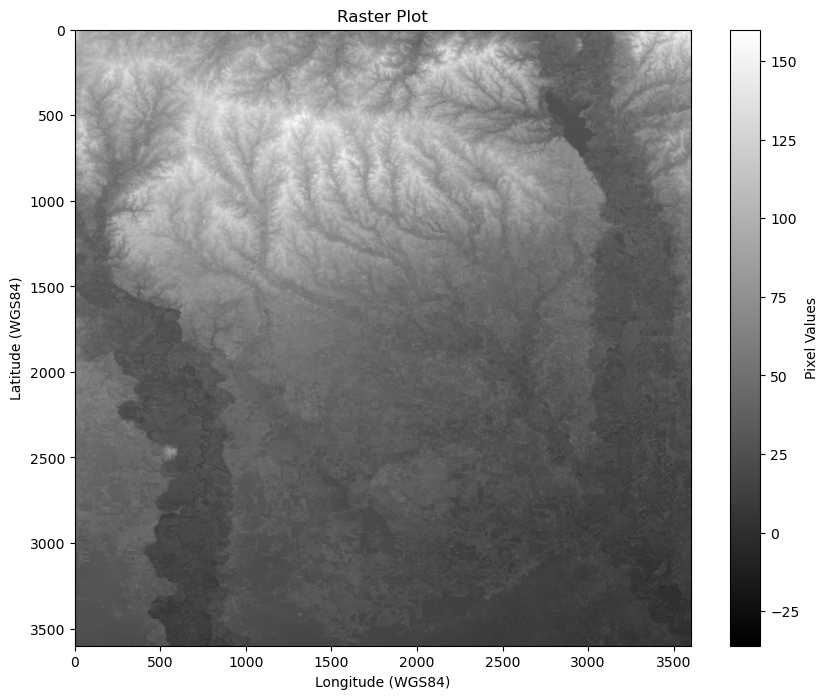

In [12]:
#Plot the raster data
plt.figure(figsize=(10,8))
plt.imshow(data,cmap='gray')
plt.colorbar(label='Pixel Values')
plt.xlabel("Longitude (WGS84)")
plt.ylabel("Latitude (WGS84)")
plt.title('Raster Plot')
plt.show()

Original City boundary CRS: EPSG:4326
City boundary reprojected to: EPSG:26915
DEM reprojected to: EPSG:26915
Lowest Elevation within city boundary: 2 meters
Lowest Point Coordinates (UTM): (385755.1378354724, 3352395.298332875)


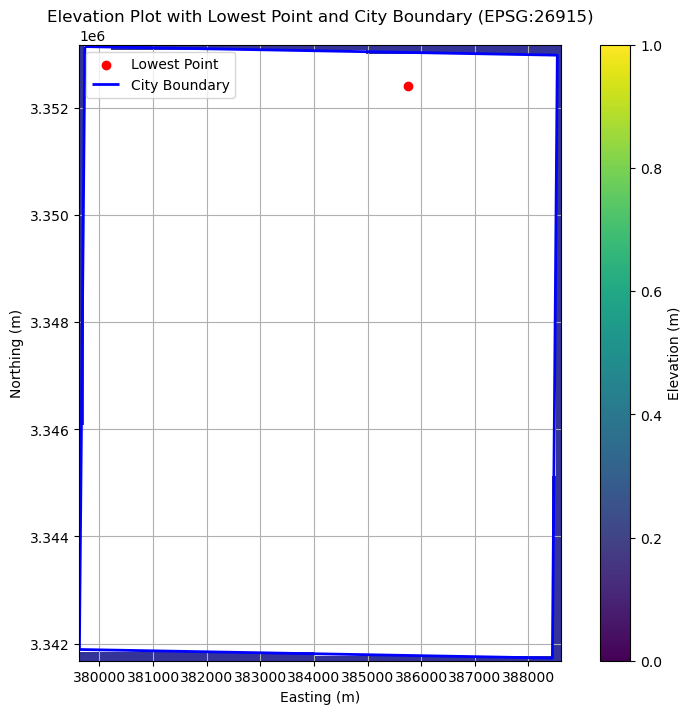

In [4]:
# Paths to your files
geopackage_file = "G:\\GIS\\Final Project\\Final_Project_Watershed\\Lumbertoncitymap.gpkg"
dem_file = "G:\\GIS\\Final Project\\Final_Project_Watershed\\n30_w095_3arc_v2_bil\\mosaic_output.tif"
reprojected_dem_file = "G:\\GIS\\Final Project\\Final_Project_Watershed\\n30_w095_3arc_v2.tif"

# Target CRS
target_crs = "EPSG:26915"

# Load the city boundary
gdf = gpd.read_file(geopackage_file)
print(f"Original City boundary CRS: {gdf.crs}")

# Reproject the city boundary
if gdf.crs != target_crs:
    gdf = gdf.to_crs(target_crs)
    print(f"City boundary reprojected to: {gdf.crs}")

# Reproject the DEM to the target CRS
with rasterio.open(dem_file) as src:
    transform, width, height = calculate_default_transform(
        src.crs, target_crs, src.width, src.height, *src.bounds
    )
    kwargs = src.meta.copy()
    kwargs.update({
        "crs": target_crs,
        "transform": transform,
        "width": width,
        "height": height
    })
    with rasterio.open(reprojected_dem_file, "w", **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=target_crs,
                resampling=Resampling.nearest
            )
print(f"DEM reprojected to: {target_crs}")

# Clip the DEM to the city boundary
with rasterio.open(reprojected_dem_file) as src:
    shapes = [feature["geometry"] for feature in gdf.iterfeatures()]
    clipped_dem, clipped_transform = mask(src, shapes, crop=True)
    clipped_dem = clipped_dem[0]  # Extract the first raster band
    nodata_value = src.nodata

# Mask NoData values
valid_data = clipped_dem[clipped_dem != nodata_value]

# Find the lowest elevation
lowest_elevation = np.min(valid_data)
print(f"Lowest Elevation within city boundary: {lowest_elevation} meters")

# Find the row and column of the lowest elevation
row, col = np.where(clipped_dem == lowest_elevation)

# Convert row and column to geographic coordinates
lowest_point_x = clipped_transform[2] + col[0] * clipped_transform[0]
lowest_point_y = clipped_transform[5] + row[0] * clipped_transform[4]
print(f"Lowest Point Coordinates (UTM): ({lowest_point_x}, {lowest_point_y})")

# Plot the clipped DEM and the lowest point with city boundary overlay
plt.figure(figsize=(10, 8))
plt.imshow(clipped_dem, cmap="terrain", extent=(
    clipped_transform[2],
    clipped_transform[2] + clipped_dem.shape[1] * clipped_transform[0],
    clipped_transform[5] + clipped_dem.shape[0] * clipped_transform[4],
    clipped_transform[5]
))
plt.scatter(lowest_point_x, lowest_point_y, color="red", label="Lowest Point", zorder=5)
plt.colorbar(label="Elevation (m)")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.title("Elevation Plot with Lowest Point and City Boundary (EPSG:26915)")

# Overlay the city boundary
gdf.boundary.plot(ax=plt.gca(), color="blue", linewidth=2, label="City Boundary")

plt.legend()
plt.grid()
plt.show()

<h4> Read DEM data

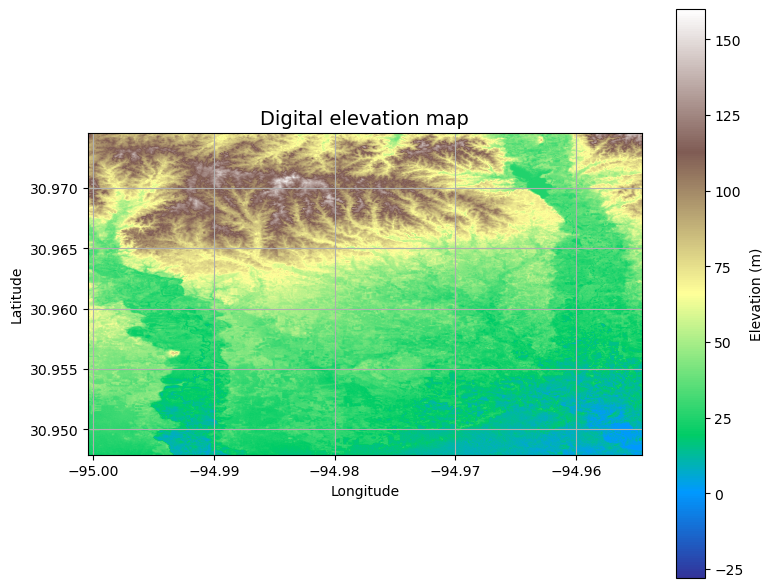

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

<h4> Condition the elevation data

In [26]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

<h4> Elevation to flow direction

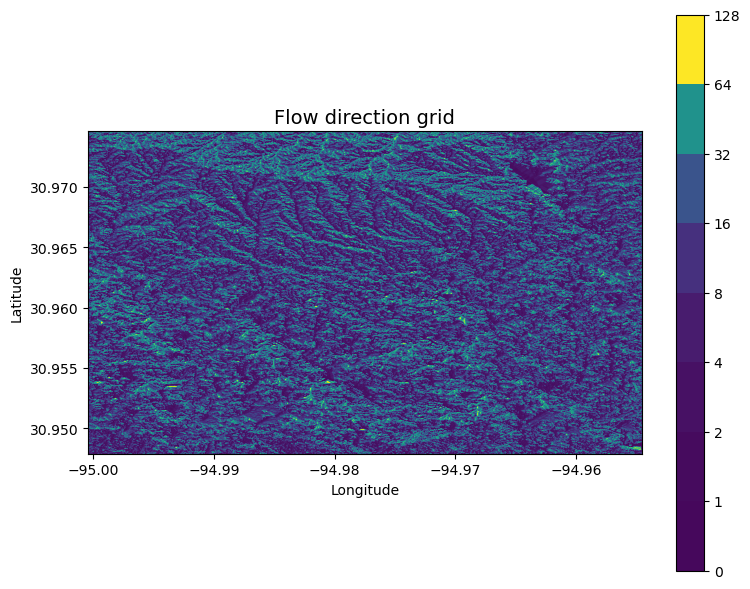

In [27]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

<h4> Compute accumulation from flow direction

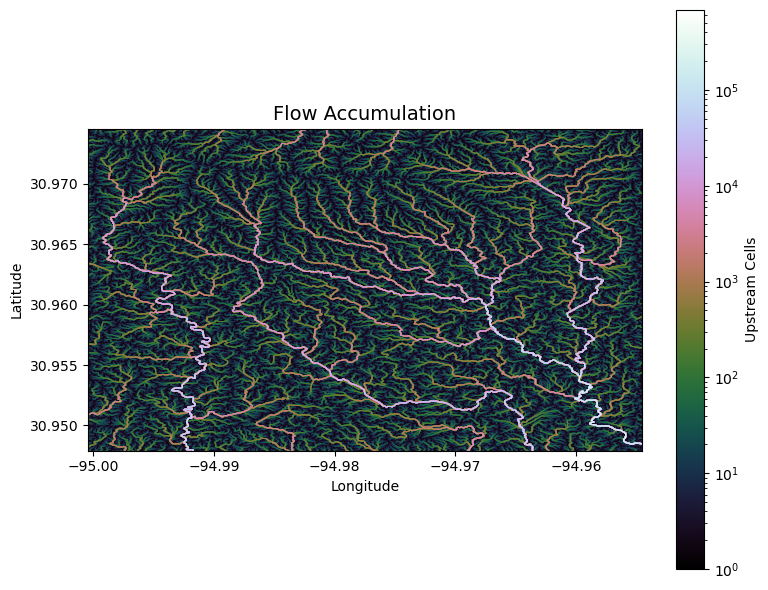

In [28]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

<h4> Delineate catchment from flow direction

Text(0.5, 1.0, 'Delineated Catchment')

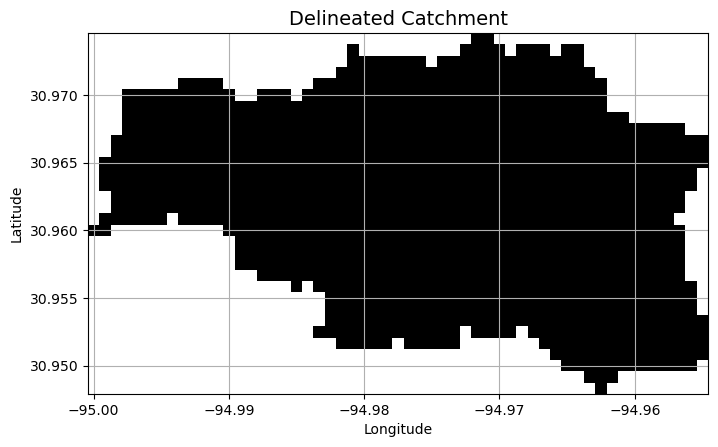

In [29]:
# Plot the catchment
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)